In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from python_files.data import GetData
from sklearn.model_selection import learning_curve
from python_files.basic_preprocessing import BasicPreprocessing
from python_files.preprocessing import Advancedprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import collections
import re
import itertools
import string
from functools import reduce
from datetime import datetime
import pickle

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.base import TransformerMixin, BaseEstimator
from scipy import stats
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Preparation

In [3]:
data = GetData().get_data()['AllMoviesDetailsCleaned']
data.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,belongs_to_collection,popularity
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,Villealfa Filmproduction Oy,Finland,21/10/1988,0,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2,NaN,3.860491
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",Villealfa Filmproduction Oy,Finland,16/10/1986,0,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3,NaN,2.292110
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,Miramax Films,United States of America,25/12/1995,4300000,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485,2,1,1,NaN,9.026586
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",Universal Pictures,Japan,15/10/1993,12136938,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69,3,2,1,NaN,5.538671
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,inLoops,Austria,01/01/2006,0,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4,1,1,5,NaN,NaN


In [5]:
test_data = pd.read_csv('../data/test data/kaggle_challenge_test.csv')
test_data.head()

,imdb_id,id,budget,genres,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,belongs_to_collection,popularity
0,tt0005078,70368.0,17311.0,Drama,en,The Cheat,"A venal, spoiled stockbroker's wife impulsivel...",Jesse L. Lasky Feature Play Company,United States of America,13/12/1915,137365.0,59.0,none,Released,NaN,The Cheat,4.8,11.0,1.0,1.0,0.0,NaN,0.680407
1,tt0009369,54242.0,250000.0,Comedy|Drama,en,Mickey,"Mickey, an orphan who has been brought up in a...",Mabel Normand Feature Film Company,United States of America,01/08/1918,8000000.0,93.0,English,Released,NaN,Mickey,7.5,4.0,1.0,1.0,1.0,NaN,0.211008
2,tt0013140,35227.0,1100000.0,Drama,en,Foolish Wives,Actor / writer / director Erich von Stroheim s...,Universal Film Manufacturing Company,United States of America,11/01/1922,0.0,117.0,English,Released,NaN,Foolish Wives,6.3,9.0,1.0,1.0,1.0,NaN,0.838095
3,tt0014429,22596.0,0.0,Comedy|Romance,en,Safety Last!,When a store clerk organizes a contest to clim...,Hal Roach Studios,United States of America,01/04/1923,0.0,70.0,English,Released,NaN,Safety Last!,7.7,70.0,1.0,1.0,1.0,NaN,4.394823
4,tt0015624,3060.0,245000.0,Drama|Romance|War,en,The Big Parade,The story of an idle rich boy who joins the US...,Metro-Goldwyn-Mayer (MGM),United States of America,05/11/1925,22000000.0,151.0,none,Released,NaN,The Big Parade,7.0,21.0,1.0,1.0,0.0,NaN,2.084627


In [6]:
imdb_id_test_data = set(test_data['imdb_id'])

In [7]:
imdb_id_train_data = set(data['imdb_id'])

In [17]:
imdb_id_not_present = list(imdb_id_train_data - imdb_id_test_data)

In [18]:
len(imdb_id_not_present)

246183

In [23]:
df_train_data = data[ data['imdb_id'].isin(imdb_id_not_present) ]

In [24]:
df_train_data.shape

(324690, 23)

In [29]:
df_train_data.to_csv('../data/kaggle_train_data.csv', index=False)

## Training

In [30]:
data = GetData().get_data()['kaggle_train_data']
data.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,belongs_to_collection,popularity
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,Villealfa Filmproduction Oy,Finland,21/10/1988,0,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2,NaN,3.860491
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",Villealfa Filmproduction Oy,Finland,16/10/1986,0,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3,NaN,2.292110
2,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,inLoops,Austria,01/01/2006,0,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4,1,1,5,NaN,NaN
3,9,0,Drama,tt0425473,de,Sonntag im August,NaN,none,Germany,02/09/2004,0,15.0,Deutsch,Released,NaN,Sunday in August,5.3,2,0,1,1,NaN,NaN
4,14,15000000,Drama,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",DreamWorks SKG,United States of America,15/09/1999,356296601,122.0,English,Released,Look closer.,American Beauty,7.9,2994,2,1,1,NaN,20.726578


In [31]:
df =data.copy()
df.shape

(324690, 23)

In [32]:
df_cleaned = BasicPreprocessing.apply(df)
df_cleaned.head()

,id,budget,genres,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
4,14,15000000,Drama,en,American Beauty,"Lester Burnham, a depressed suburban father in...",DreamWorks SKG,United States of America,15/09/1999,356296601,122.0,Look closer.,American Beauty,7.9,2994,2,1,1,20.726578,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,18,90000000,Adventure|Fantasy|Action|Thriller|Science Fiction,en,The Fifth Element,"In 2257, a taxi driver is unintentionally give...",Columbia Pictures,France,07/05/1997,263920180,126.0,There is no future without it.,The Fifth Element,7.2,3629,2,1,3,24.305260,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
8,22,140000000,Adventure|Fantasy|Action,en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,United States of America,09/07/2003,655011224,143.0,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,7.4,6368,2,1,1,47.326665,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,24,30000000,Action|Crime,en,Kill Bill: Vol. 1,An assassin is shot at the altar by her ruthle...,Miramax Films,United States of America,10/10/2003,180949000,111.0,Go for the kill.,Kill Bill: Vol. 1,7.7,4486,3,1,3,25.261865,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,25,72000000,Drama|War,en,Jarhead,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,Germany,04/11/2005,96889998,125.0,Welcome to the suck.,Jarhead,6.5,722,4,2,4,9.997032,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


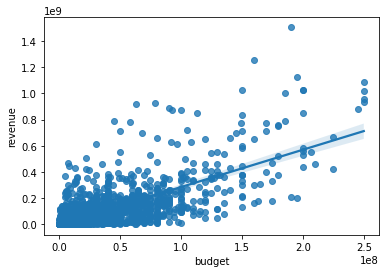

In [33]:
import seaborn as sns
sns.regplot(x='budget', y='revenue', data=df_cleaned);

In [34]:
X = df_cleaned.drop(columns = ['revenue'])
y = df_cleaned['revenue']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Print split result
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1899, 39)
(475, 39)
(1899,)
(475,)


In [36]:
X_train_processed, list_top_30 = Advancedprocessing.process(X_train)
X_test_processed, _ = Advancedprocessing.process(X_test, train_set=False)

/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '23/11/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '27/09/2007' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:57: UserWarning: Parsing '23/07/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df_copy['release_date'] = pd.to_datetime(df_copy['release_date'], infer_datetime_format=True)
/home/sourav/code/Urus1201/data-movie-re

/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning:

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [37]:
# Create validation sets
X_train_processed_part, X_val, y_train_part, y_val = train_test_split(X_train_processed, 
                                                              y_train, 
                                                              test_size = 0.2,
                                                              random_state = 42)

# Print split result
print(X_train_processed_part.shape)
print(X_val.shape)
print(y_train_part.shape)
print(y_val.shape)

(1519, 148)
(380, 148)
(1519,)
(380,)


In [38]:
# transform the y test and train to log scale
y_train_part_log = y_train_part.apply(lambda x: np.log(x + 1))
y_val_log = y_val.apply(lambda x: np.log(x + 1))
y_test_log = y_test.apply(lambda x: np.log(x + 1))

In [39]:
# RobustScaler for rest of the numerical features
rbst_scaler = RobustScaler()
features = ['runtime', 'release_age', 'production_companies_number', 'production_countries_number', 'popularity', #'vote_average', 'vote_count',
            'actor_number', 'director_number', 'producer_number', 'release_age', 'budget_year_ratio'] #'spoken_languages_number'

X_train_processed_part[features] = rbst_scaler.fit_transform(X_train_processed_part[features])

X_val[features] = rbst_scaler.transform(X_val[features])

X_test_processed[features] = rbst_scaler.transform(X_test_processed[features])

In [40]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'mean')

imputer.fit(X_train_processed_part[['popularity', 'runtime']])

X_train_processed_part[['popularity', 'runtime']] = imputer.transform(X_train_processed_part[['popularity', 'runtime']])
X_val[['popularity', 'runtime']] = imputer.transform(X_val[['popularity', 'runtime']])
X_test_processed[['popularity', 'runtime']] = imputer.transform(X_test_processed[['popularity', 'runtime']])

In [46]:
# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_processed_part, label=y_train_part_log)
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [47]:
# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRMSE {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))

In [48]:
# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)

learning_rate: 0.3, max_depth: 6
	RMSE 1.3884824 for 23 rounds
learning_rate: 0.3, max_depth: 8
	RMSE 1.4190362 for 17 rounds
learning_rate: 0.3, max_depth: 10
	RMSE 1.4343754 for 17 rounds
Best params: learning_rate of 0.3, max_depth of 6, RMSE: 1.3884824
learning_rate: 0.1, max_depth: 6
	RMSE 1.3539366000000002 for 54 rounds
learning_rate: 0.1, max_depth: 8
	RMSE 1.3748278 for 65 rounds
learning_rate: 0.1, max_depth: 10
	RMSE 1.3782828 for 78 rounds
Best params: learning_rate of 0.1, max_depth of 6, RMSE: 1.3539366000000002
learning_rate: 0.01, max_depth: 6
	RMSE 1.353922 for 567 rounds
learning_rate: 0.01, max_depth: 8
	RMSE 1.364407 for 692 rounds
learning_rate: 0.01, max_depth: 10
	RMSE 1.3670956 for 743 rounds
Best params: learning_rate of 0.01, max_depth of 6, RMSE: 1.353922


In [49]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through alpha and subsample values for XGBoost model
grid_search_xgb('alpha', 'subsample', alpha, subsample)

alpha: 0, subsample: 0.5
	RMSE 1.3558234000000002 for 626 rounds
alpha: 0, subsample: 0.7
	RMSE 1.3450416 for 565 rounds
alpha: 0, subsample: 1
	RMSE 1.353922 for 567 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 1.3450416
alpha: 5, subsample: 0.5
	RMSE 1.3598143999999999 for 633 rounds
alpha: 5, subsample: 0.7
	RMSE 1.349959 for 652 rounds
alpha: 5, subsample: 1
	RMSE 1.3592959999999998 for 602 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 1.3450416
alpha: 10, subsample: 0.5
	RMSE 1.3581501999999999 for 856 rounds
alpha: 10, subsample: 0.7
	RMSE 1.3572786000000001 for 740 rounds
alpha: 10, subsample: 1
	RMSE 1.3618254 for 802 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 1.3450416


In [50]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.7
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through min_child_weight and colsample_bytree values for XGBoost model
grid_search_xgb('min_child_weight', 'colsample_bytree', min_child_weight, colsample_bytree)

min_child_weight: 1, colsample_bytree: 0.5
	RMSE 1.3420238 for 622 rounds
min_child_weight: 1, colsample_bytree: 0.7
	RMSE 1.3409581999999998 for 667 rounds
min_child_weight: 1, colsample_bytree: 1
	RMSE 1.3450416 for 565 rounds
Best params: min_child_weight of 1, colsample_bytree of 0.7, RMSE: 1.3409581999999998
min_child_weight: 3, colsample_bytree: 0.5
	RMSE 1.33398 for 629 rounds
min_child_weight: 3, colsample_bytree: 0.7
	RMSE 1.3362852 for 575 rounds
min_child_weight: 3, colsample_bytree: 1
	RMSE 1.3360679999999998 for 546 rounds
Best params: min_child_weight of 3, colsample_bytree of 0.5, RMSE: 1.33398
min_child_weight: 6, colsample_bytree: 0.5
	RMSE 1.3262088 for 624 rounds
min_child_weight: 6, colsample_bytree: 0.7
	RMSE 1.3311322 for 561 rounds
min_child_weight: 6, colsample_bytree: 1
	RMSE 1.3291030000000001 for 558 rounds
Best params: min_child_weight of 6, colsample_bytree of 0.5, RMSE: 1.3262088


In [51]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.7
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6
# Update min_child_weight and colsample_bytree
parameters_xgb['min_child_weight'] = 6
parameters_xgb['colsample_bytree'] = 0.5

In [52]:
# Predicting values
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(test_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(cross_set)

[0]	Test-rmse:15.89821
[1]	Test-rmse:15.74093
[2]	Test-rmse:15.58475
[3]	Test-rmse:15.43145
[4]	Test-rmse:15.27856
[5]	Test-rmse:15.12699
[6]	Test-rmse:14.97712
[7]	Test-rmse:14.82921
[8]	Test-rmse:14.68200
[9]	Test-rmse:14.53719
[10]	Test-rmse:14.39382
[11]	Test-rmse:14.25197
[12]	Test-rmse:14.11087
[13]	Test-rmse:13.97164
[14]	Test-rmse:13.83359
[15]	Test-rmse:13.69701
[16]	Test-rmse:13.56234
[17]	Test-rmse:13.42819
[18]	Test-rmse:13.29515
[19]	Test-rmse:13.16374
[20]	Test-rmse:13.03415
[21]	Test-rmse:12.90590
[22]	Test-rmse:12.77880
[23]	Test-rmse:12.65298
[24]	Test-rmse:12.52824
[25]	Test-rmse:12.40486
[26]	Test-rmse:12.28227
[27]	Test-rmse:12.16169
[28]	Test-rmse:12.04149
[29]	Test-rmse:11.92332
[30]	Test-rmse:11.80713
[31]	Test-rmse:11.69155
[32]	Test-rmse:11.57678
[33]	Test-rmse:11.46334
[34]	Test-rmse:11.35020
[35]	Test-rmse:11.23888
[36]	Test-rmse:11.12875
[37]	Test-rmse:11.02040
[38]	Test-rmse:10.91229
[39]	Test-rmse:10.80513
[40]	Test-rmse:10.69985
[41]	Test-rmse:10.59549
[4

[344]	Test-rmse:1.58935
[345]	Test-rmse:1.58729
[346]	Test-rmse:1.58557
[347]	Test-rmse:1.58380
[348]	Test-rmse:1.58240
[349]	Test-rmse:1.58075
[350]	Test-rmse:1.57880
[351]	Test-rmse:1.57728
[352]	Test-rmse:1.57546
[353]	Test-rmse:1.57370
[354]	Test-rmse:1.57215
[355]	Test-rmse:1.57016
[356]	Test-rmse:1.56835
[357]	Test-rmse:1.56692
[358]	Test-rmse:1.56559
[359]	Test-rmse:1.56457
[360]	Test-rmse:1.56304
[361]	Test-rmse:1.56198
[362]	Test-rmse:1.56009
[363]	Test-rmse:1.55881
[364]	Test-rmse:1.55754
[365]	Test-rmse:1.55657
[366]	Test-rmse:1.55541
[367]	Test-rmse:1.55417
[368]	Test-rmse:1.55292
[369]	Test-rmse:1.55176
[370]	Test-rmse:1.55079
[371]	Test-rmse:1.54959
[372]	Test-rmse:1.54875
[373]	Test-rmse:1.54745
[374]	Test-rmse:1.54650
[375]	Test-rmse:1.54575
[376]	Test-rmse:1.54450
[377]	Test-rmse:1.54362
[378]	Test-rmse:1.54242
[379]	Test-rmse:1.54116
[380]	Test-rmse:1.54045
[381]	Test-rmse:1.53945
[382]	Test-rmse:1.53810
[383]	Test-rmse:1.53718
[384]	Test-rmse:1.53636
[385]	Test-rmse:

[686]	Test-rmse:1.47641
[687]	Test-rmse:1.47630
[688]	Test-rmse:1.47624
[689]	Test-rmse:1.47611
[690]	Test-rmse:1.47602
[691]	Test-rmse:1.47617
[692]	Test-rmse:1.47615
[693]	Test-rmse:1.47612
[694]	Test-rmse:1.47605
[695]	Test-rmse:1.47576
[696]	Test-rmse:1.47573
[697]	Test-rmse:1.47564
[698]	Test-rmse:1.47550
[699]	Test-rmse:1.47566
[700]	Test-rmse:1.47553
[701]	Test-rmse:1.47528
[702]	Test-rmse:1.47544
[703]	Test-rmse:1.47549
[704]	Test-rmse:1.47525
[705]	Test-rmse:1.47551
[706]	Test-rmse:1.47571
[707]	Test-rmse:1.47541
[708]	Test-rmse:1.47548
[709]	Test-rmse:1.47517
[710]	Test-rmse:1.47508
[711]	Test-rmse:1.47505
[712]	Test-rmse:1.47503
[713]	Test-rmse:1.47478
[714]	Test-rmse:1.47468
[715]	Test-rmse:1.47453
[716]	Test-rmse:1.47432
[717]	Test-rmse:1.47423
[718]	Test-rmse:1.47403
[719]	Test-rmse:1.47393
[720]	Test-rmse:1.47382
[721]	Test-rmse:1.47387
[722]	Test-rmse:1.47397
[723]	Test-rmse:1.47381
[724]	Test-rmse:1.47390
[725]	Test-rmse:1.47386
[726]	Test-rmse:1.47354
[727]	Test-rmse:

In [53]:
# Create dataframe with predicted values
comp_df = pd.DataFrame({"actual": np.expm1(y_test_log), "predictions": np.expm1(clf_xgb.predict(cross_set))})

# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
125384,1.200000e+07,2.543403e+06,-9.456597e+06,78.804975,bad
57200,1.194795e+07,6.009162e+06,-5.938792e+06,49.705510,bad
216,3.135423e+08,2.145111e+08,-9.903120e+07,31.584635,bad
174278,2.000000e+06,2.879138e+06,8.791385e+05,43.956925,bad
108,6.000000e+06,3.838425e+06,-2.161575e+06,36.026246,bad
...,...,...,...,...,...
2949,3.002575e+08,4.394981e+08,1.392407e+08,46.373756,bad
175666,7.831130e+08,3.813709e+08,-4.017420e+08,51.300648,bad
5980,1.875025e+07,9.520085e+06,-9.230161e+06,49.226879,bad
20561,2.042530e+06,7.377200e+06,5.334670e+06,261.179493,bad


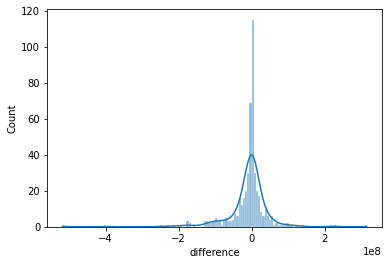

In [54]:
# visual check
sns.histplot(comp_df['difference'], kde=True, edgecolor='w');

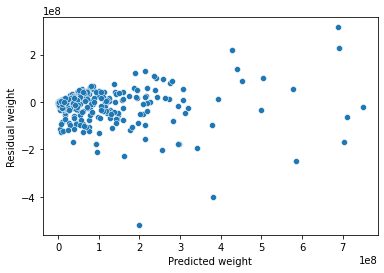

In [55]:
# Check with Residuals vs. Fitted scatterplot
sns.scatterplot(x=comp_df['predictions'], y=comp_df['difference'])
plt.xlabel('Predicted weight')
plt.ylabel('Residual weight');

In [56]:
# Saving the best XGBoost model
pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))

## Testing

In [124]:
test_data = GetData().get_data()['kaggle_challenge_test']
test_data.head()

,imdb_id,id,budget,genres,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,belongs_to_collection,popularity,belongs_to_collection.1,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,tt0005078,70368.0,17311.0,Drama,en,The Cheat,"A venal, spoiled stockbroker's wife impulsivel...",Jesse L. Lasky Feature Play Company,United States of America,13/12/1915,137365.0,59.0,none,Released,NaN,The Cheat,4.8,11.0,1.0,1.0,0.0,NaN,0.680407,NaN,NaN,NaN,NaN
1,tt0009369,54242.0,250000.0,Comedy|Drama,en,Mickey,"Mickey, an orphan who has been brought up in a...",Mabel Normand Feature Film Company,United States of America,1/8/1918,8000000.0,93.0,English,Released,NaN,Mickey,7.5,4.0,1.0,1.0,1.0,NaN,0.211008,NaN,NaN,NaN,NaN
2,tt0013140,35227.0,1100000.0,Drama,en,Foolish Wives,Actor / writer / director Erich von Stroheim s...,Universal Film Manufacturing Company,United States of America,11/1/1922,0.0,117.0,English,Released,NaN,Foolish Wives,6.3,9.0,1.0,1.0,1.0,NaN,0.838095,NaN,NaN,NaN,NaN
3,tt0014429,22596.0,0.0,Comedy|Romance,en,Safety Last!,When a store clerk organizes a contest to clim...,Hal Roach Studios,United States of America,1/4/1923,0.0,70.0,English,Released,NaN,Safety Last!,7.7,70.0,1.0,1.0,1.0,NaN,4.394823,NaN,NaN,NaN,NaN
4,tt0015624,3060.0,245000.0,Drama|Romance|War,en,The Big Parade,The story of an idle rich boy who joins the US...,Metro-Goldwyn-Mayer (MGM),United States of America,5/11/1925,22000000.0,151.0,none,Released,NaN,The Big Parade,7.0,21.0,1.0,1.0,0.0,NaN,2.084627,NaN,NaN,NaN,NaN


In [125]:
test_data.drop(columns = ['belongs_to_collection.1', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'], inplace = True)

In [126]:
test_data_processed = BasicPreprocessing.apply(test_data, train_set = False)
test_data_processed.head()

,id,budget,genres,original_language,original_title,overview,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,70368.0,17311.0,Drama,en,The Cheat,"A venal, spoiled stockbroker's wife impulsivel...",Jesse L. Lasky Feature Play Company,United States of America,13/12/1915,137365.0,59.0,NaN,The Cheat,4.8,11.0,1.0,1.0,0.0,0.680407,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,54242.0,250000.0,Comedy|Drama,en,Mickey,"Mickey, an orphan who has been brought up in a...",Mabel Normand Feature Film Company,United States of America,1/8/1918,8000000.0,93.0,NaN,Mickey,7.5,4.0,1.0,1.0,1.0,0.211008,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35227.0,1100000.0,Drama,en,Foolish Wives,Actor / writer / director Erich von Stroheim s...,Universal Film Manufacturing Company,United States of America,11/1/1922,0.0,117.0,NaN,Foolish Wives,6.3,9.0,1.0,1.0,1.0,0.838095,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,22596.0,0.0,Comedy|Romance,en,Safety Last!,When a store clerk organizes a contest to clim...,Hal Roach Studios,United States of America,1/4/1923,0.0,70.0,NaN,Safety Last!,7.7,70.0,1.0,1.0,1.0,4.394823,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3060.0,245000.0,Drama|Romance|War,en,The Big Parade,The story of an idle rich boy who joins the US...,Metro-Goldwyn-Mayer (MGM),United States of America,5/11/1925,22000000.0,151.0,NaN,The Big Parade,7.0,21.0,1.0,1.0,0.0,2.084627,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [142]:
test_data_processed.dropna( axis=0, how='any', subset=['revenue'], inplace= True )

In [143]:
X_test_final = test_data_processed.drop(columns = 'revenue')
y_final = test_data_processed['revenue']

In [144]:
X_test_processed, _ = Advancedprocessing.process(X_test_final, train_set=False)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning:

In [145]:
X_test_processed[features] = rbst_scaler.transform(X_test_processed[features])

In [146]:
X_test_processed[['popularity', 'runtime']] = imputer.transform(X_test_processed[['popularity', 'runtime']])

In [147]:
clf_xgb = pickle.load(open('xgboost.sav', 'rb'))

In [148]:
X_test_processed

,runtime,vote_average,vote_count,production_companies_number,production_countries_number,popularity,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,actor_number,director_number,producer_number,week_sin,week_cos,release_age,budget_year_ratio,Steven Spielberg_name,Paul W.S. Anderson_name,Woody Allen_name,Steven Soderbergh_name,Peter Hyams_name,Martin Scorsese_name,Robert Rodriguez_name,Wes Craven_name,Alfred Hitchcock_name,Joel Schumacher_name,Peter Jackson_name,Rob Reiner_name,Clint Eastwood_name,Francis Ford Coppola_name,Brian De Palma_name,Tim Burton_name,Andy Fickman_name,Ron Howard_name,Renny Harlin_name,Vysakh_name,John Huston_name,Billy Wilder_name,Ridley Scott_name,Roland Emmerich_name,James Wan_name,Richard Linklater_name,Michael Bay_name,Wolfgang Petersen_name,Peter Weir_name,Ivan Reitman_name,Neal H. Moritz_name,Gale Anne Hurd_name,Luc Besson_name,Jerry Bruckheimer_name,Brian Grazer_name,Tim Bevan_name,Arnon Milchan_name,Ronnie Screwvala_name,Scott Rudin_name,Joel Silver_name,Albert R. Broccoli_name,Barbara Broccoli_name,Steve Golin_name,James G. Robinson_name,Tom Rosenberg_name,Danny DeVito_name,Roger Birnbaum_name,Moshe Diamant_name,Michael De Luca_name,Bruce Cohen_name,S. S. Chakravarthy_name,Brad Pitt_name,Edward R. Pressman_name,John Davis_name,Universal Pictures_name,Paramount Pictures_name,Twentieth Century Fox Film Corporation_name,Columbia Pictures_name,New Line Cinema_name,Walt Disney Pictures_name,Warner Bros._name,United Artists_name,TriStar Pictures_name,Metro-Goldwyn-Mayer (MGM)_name,Miramax Films_name,Columbia Pictures Corporation_name,Village Roadshow Pictures_name,Fox Searchlight Pictures_name,Touchstone Pictures_name,Summit Entertainment_name,Hollywood Pictures_name,BBC Films_name,DreamWorks SKG_name,Lionsgate_name,Orion Pictures_name,Regency Enterprises_name,StudioCanal_name,Lakeshore Entertainment_name,Fox 2000 Pictures_name,Eon Productions_name,Lions Gate Films_name,Lucasfilm_name,Dune Entertainment_name,Original Film_name,United States of America_name,India_name,United Kingdom_name,France_name,Germany_name,Canada_name,Russia_name,Australia_name,Japan_name,Italy_name,China_name,Spain_name,Hong Kong_name,Mexico_name,South Korea_name,New Zealand_name,Belgium_name,Singapore_name,Netherlands_name,Ireland_name,Czech Republic_name,Thailand_name,Brazil_name,Israel_name,Hungary_name,Denmark_name,Malaysia_name,Sweden_name,Greece_name,Pakistan_name
0,-1.777778,4.8,11.0,-0.333333,0.0,-1.255443,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.384615,0.0,-0.5,0.000000,1.000000,5.933333,-0.474498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.518519,7.5,4.0,-0.333333,0.0,-1.331619,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.615385,1.0,0.0,0.354605,0.935016,5.800000,-0.466632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.370370,6.3,9.0,-0.333333,0.0,-1.229852,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.307692,0.0,-0.5,0.239316,0.970942,5.533333,-0.437968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.370370,7.7,70.0,-0.333333,0.0,-0.652648,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.846154,1.0,-1.0,0.663123,0.748511,5.466667,-0.475085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [149]:
dtest = xgb.DMatrix(X_test_processed)

test_pred = clf_xgb.predict(dtest)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [150]:
test_pred

array([14.405314, 14.12444 , 15.437257, ..., 15.508687, 13.329223,
       12.583693], dtype=float32)

In [151]:
test_pred.shape

(4380,)

In [152]:
from sklearn.metrics import r2_score

score = r2_score( y_final, np.expm1(test_pred))

In [153]:
score

0.7684453971087719